# Calibrate exact Voigt Profiles

The resolution seems off.  Let's calibrate blasé with the LFC spectra.

In [1]:
import torch
from blase.emulator import SparseLogEmulator, ExtrinsicModel, InstrumentalModel
import matplotlib.pyplot as plt
from blase.utils import doppler_grid
import astropy.units as u
import numpy as np
from specutils import Spectrum1D

import seaborn as sns

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

Version 1.9.1.post3 of PyTorch does not offer erfcx, defaulting to unstable...


In [2]:
device

'cpu'

## Make fake data with known signals

In [3]:
from scipy.special import voigt_profile
fwhm_per_sigma = 2*np.sqrt(2*np.log(2))
fwhm_per_sigma

2.3548200450309493

In [4]:
x_vector = np.arange(10630, 10768.0, 0.06)
y_vector = np.zeros_like(x_vector)
spectrum = Spectrum1D(spectral_axis=x_vector*u.Angstrom, 
           flux=y_vector*u.dimensionless_unscaled)

In [5]:
spectrum.bin_edges

<Quantity [10629.97, 10630.03, 10630.09, ..., 10767.85, 10767.91, 10767.97] Angstrom>

In [6]:
true_lam_centers = np.arange(10631.6, 10766.7, 1.14)

In [7]:
n_lines = len(true_lam_centers)
n_lines

119

In [8]:
true_sigmas = np.random.uniform(low=0.09, high=0.16, size=n_lines)
true_gammas = np.random.uniform(low=0.00, high=0.05, size=n_lines)
true_amplitudes = np.random.uniform(low=0.1, high=1.0, size=n_lines)

In [9]:
wl_2D = x_vector[:, np.newaxis] - true_lam_centers[np.newaxis, :]

In [10]:
normalized_lines = voigt_profile(wl_2D, true_sigmas, true_gammas)
lines = true_amplitudes * normalized_lines

The lines overlap:

In [11]:
lines.shape

(2300, 119)

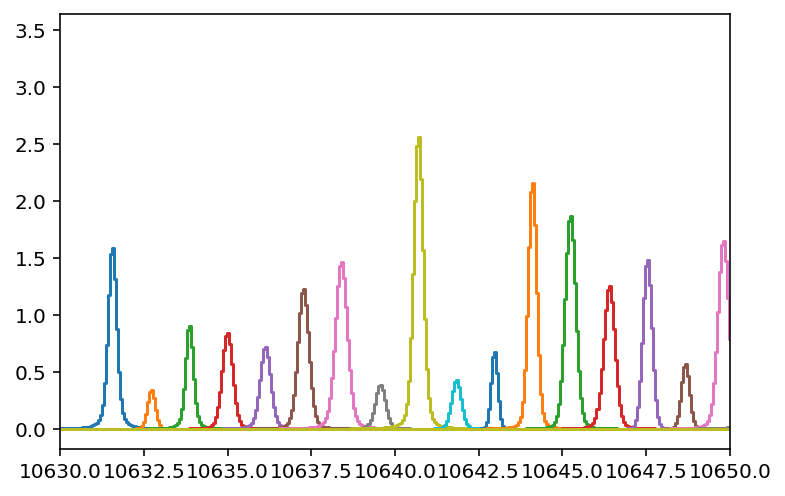

In [12]:
for i in range(n_lines):
    plt.step(x_vector, lines[:, i])
    plt.xlim(10630, 10650)

In [13]:
new_flux = lines.sum(axis=1) * u.dimensionless_unscaled
spectrum = spectrum._copy(flux=new_flux)

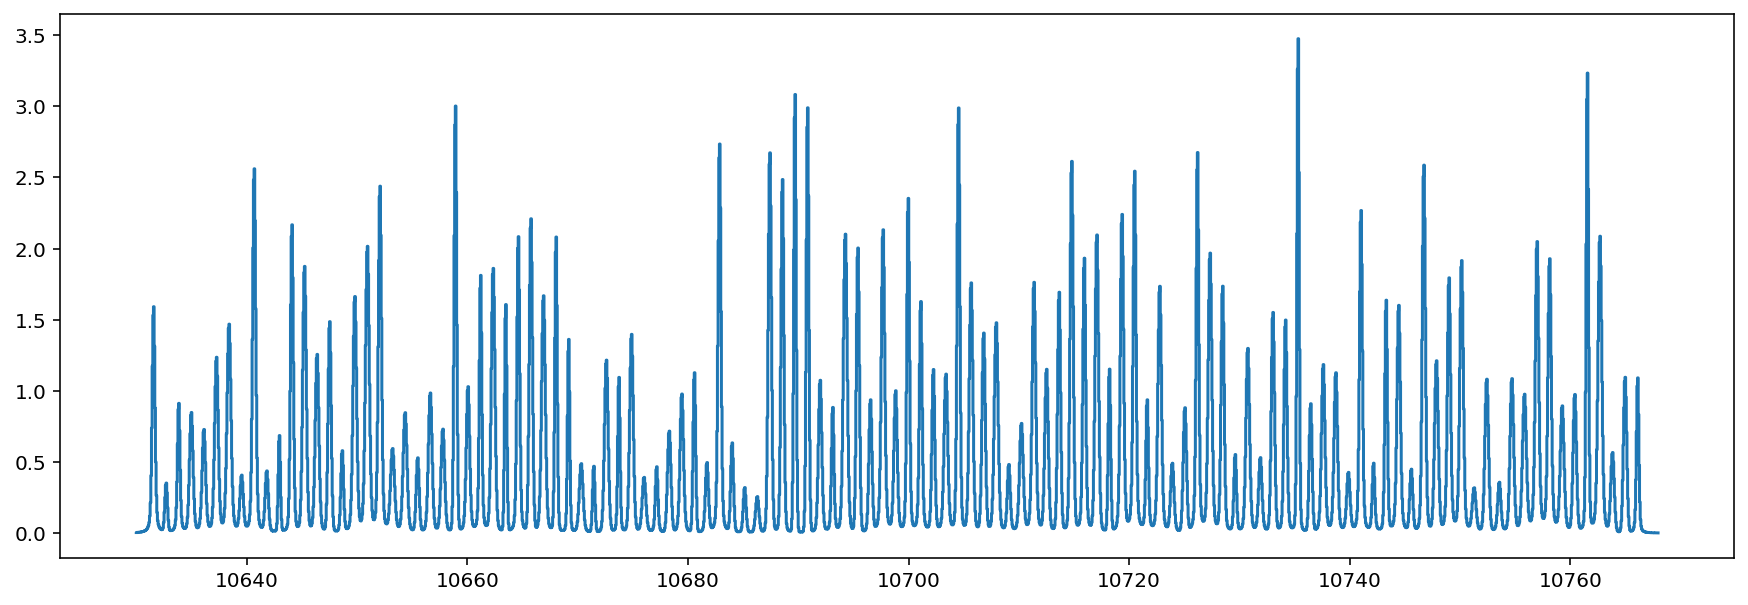

In [14]:
plt.figure(figsize=(15, 5))
plt.step(spectrum.wavelength, spectrum.flux)

In [15]:
guess_sigma = 0.1
guess_gamma = 0.05

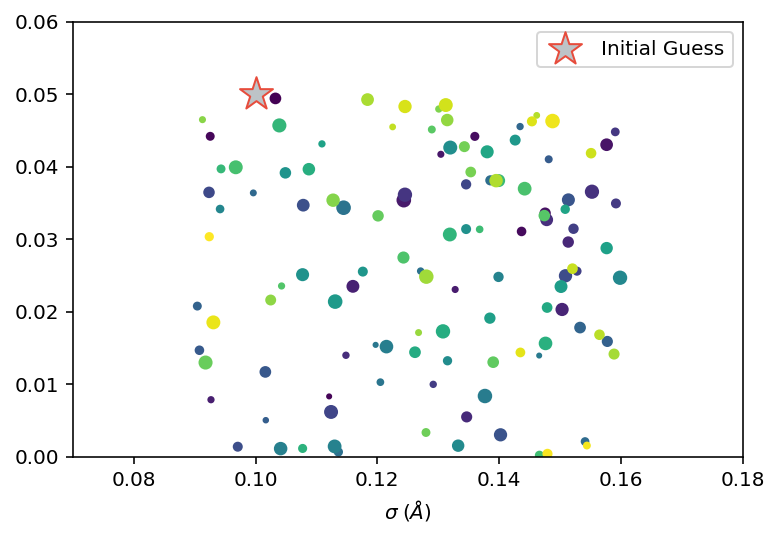

In [16]:
plt.scatter(true_sigmas, true_gammas, s=true_amplitudes*40, c=true_lam_centers)
plt.xlabel('$\sigma \; (\AA)$')
plt.scatter([guess_sigma], [guess_gamma], marker='*', s=300, color='#bdc3c7', ec='#e74c3c', label='Initial Guess')
plt.xlim(0.07, 0.18)
plt.ylim(0, 0.06)
plt.legend();

The lines have a range of True known properties.

## Pre-process the data
We will quickly pre-process the HPF spectrum with the [muler](https://muler.readthedocs.io/en/latest/) library

In [17]:
from scipy.signal import find_peaks

In [18]:
peaks = find_peaks(spectrum.flux.value, distance=10, prominence=0.01)[0]
assert len(peaks) == n_lines # We should find all the emission lines

In [19]:
peak_coords = spectrum.wavelength.value[peaks]

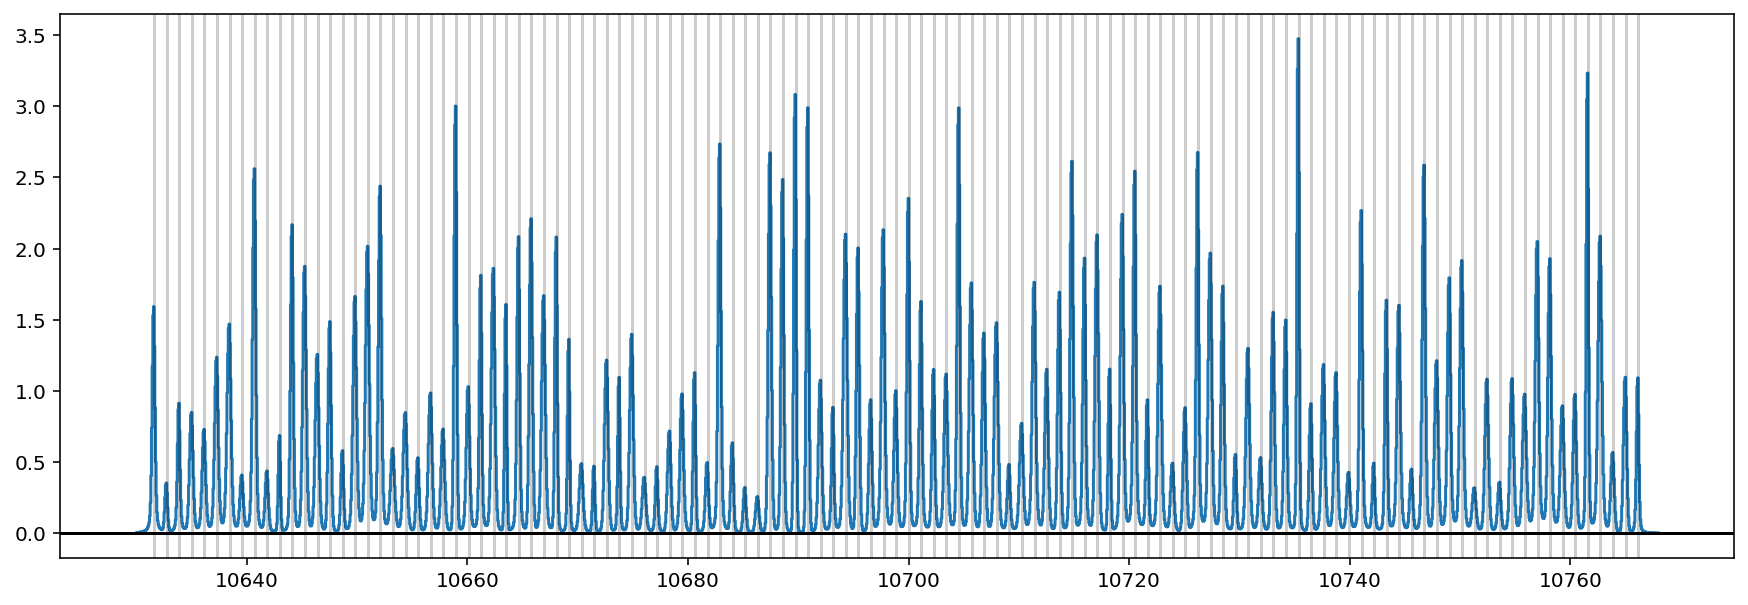

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.step(spectrum.wavelength, spectrum.flux)

for xv in peak_coords:
    ax.axvline(xv, linestyle='solid', alpha=0.2, color='k')
    
ax.axhline(0.0, color='k');

We have detected all the spectral lines

In [21]:
wl_lo = 10630-30.0
wl_hi = 10770+30.0
wavelength_grid = doppler_grid(wl_lo, wl_hi)

## Model the lines with blasé

In [22]:
from blase.emulator import SparseLogEmissionEmulator

In [23]:
from collections import OrderedDict

In [24]:
state_dict = OrderedDict({'lam_centers':torch.tensor(true_lam_centers),
                  'amplitudes':torch.log(torch.tensor(true_amplitudes)), 
                  'sigma_widths':torch.log(torch.repeat_interleave(torch.tensor(guess_sigma), n_lines)), 
                  'gamma_widths':torch.log(torch.repeat_interleave(torch.tensor(guess_gamma), n_lines)),
                  'a_coeff':torch.tensor(1.0), 
                  'b_coeff':torch.tensor(0.0),
                  'c_coeff':torch.tensor(0.0), 
                  'radial_velocity':torch.tensor(0.0)})

### Guess and check

In [25]:
emission_model = SparseLogEmissionEmulator(wavelength_grid, 
                                     init_state_dict=state_dict, wing_cut_pixels=100, device=device)
emission_model.to(device)

Initializing a sparse model with 119 spectral lines


SparseLogEmissionEmulator()

In [26]:
import math

In [27]:
math.sqrt(math.pi)

1.7724538509055159

In [28]:
with torch.no_grad():
    emission_spec = emission_model.forward()

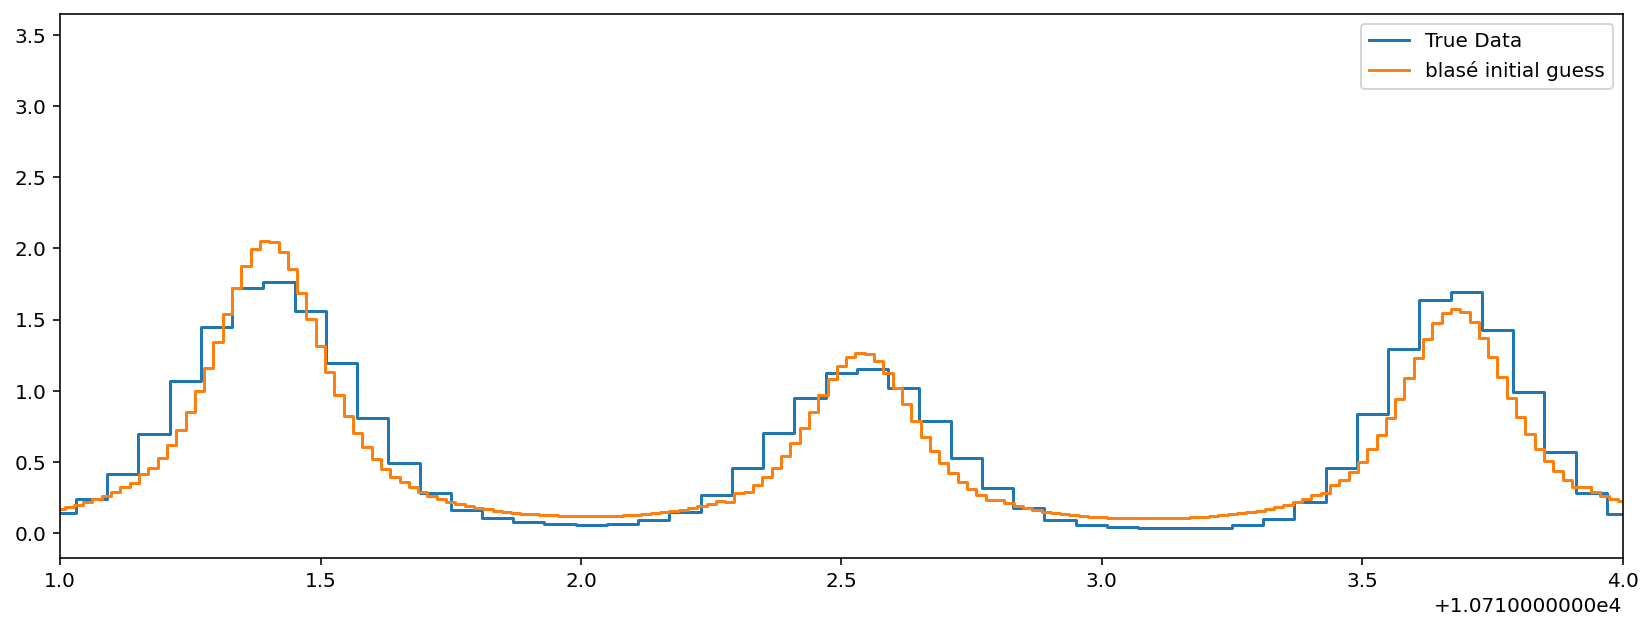

In [29]:
plt.figure(figsize=(14, 5))
plt.step(spectrum.wavelength, spectrum.flux, where='mid', label='True Data')
plt.step(wavelength_grid, emission_spec, where='mid', label='blasé initial guess')
plt.xlim(10711, 10714)
plt.legend();

#### Instrumental model

In [30]:
instrumental_model = InstrumentalModel(spectrum.bin_edges.value, wavelength_grid, device=device)
instrumental_model.to(device)

InstrumentalModel(
  (linear_model): Linear(in_features=15, out_features=1, bias=True)
)

In [31]:
#instrumental_model.ln_sigma_angs.data = torch.log(torch.tensor(0.064))

## Transfer learn a semi-empirical model

Here we compare the resampled joint model to the observed data to "transfer learn" underlying super resolution spectra.

In [32]:
from torch import nn
from tqdm import trange
import torch.optim as optim

In [33]:
data_target = torch.tensor(
    spectrum.flux.value.astype(np.float64), device=device, dtype=torch.float64
)

data_wavelength = torch.tensor(
    spectrum.wavelength.value.astype(np.float64), device=device, dtype=torch.float64
)

In [34]:
loss_fn = nn.MSELoss(reduction="mean")

### Fix certain parameters, allow others to vary
As we have seen before, you can fix parameters by "turning off their gradients".  We will start by turning off *ALL* gradients.  Then turn on some.

In [35]:
# Fix all stellar parameters except amplitude and RV
emission_model.amplitudes.requires_grad = True
emission_model.radial_velocity.requires_grad = False
emission_model.lam_centers.requires_grad = True
emission_model.sigma_widths.requires_grad = True
emission_model.gamma_widths.requires_grad = True
emission_model.a_coeff.requires_grad = False
emission_model.b_coeff.requires_grad = False
emission_model.c_coeff.requires_grad = False

# Fix all instrument parameters
instrumental_model.ln_sigma_angs.requires_grad = False
instrumental_model.linear_model.weight.requires_grad = False
instrumental_model.linear_model.bias.requires_grad = False

In [36]:
tuning_params = list(filter(lambda p: p.requires_grad, emission_model.parameters()))

In [37]:
optimizer = optim.Adam(tuning_params,0.05,amsgrad=True)         

In [38]:
n_epochs = 1000
losses = []

First, we need to assign uncertainty to the data in order to weigh the prior against new data:

In [39]:
#per_pixel_uncertainty = torch.tensor(0.01, device=device, dtype=torch.float64)

In [40]:
t_iter = trange(n_epochs, desc="Training", leave=True)
for epoch in t_iter:
    emission_model.train()
    instrumental_model.train()
    
    flux = emission_model.forward()
    detector_flux = instrumental_model.resample_to_data(flux)
    
    loss = loss_fn(detector_flux, data_target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    t_iter.set_description("Training Loss: {:0.8f}".format(loss.item()))

Training Loss: 0.00008523: 100%|████████████| 1000/1000 [00:47<00:00, 21.20it/s]


### Spot check the transfer-learned joint model

In [41]:
residual = spectrum.flux - detector_flux.detach().cpu().numpy()

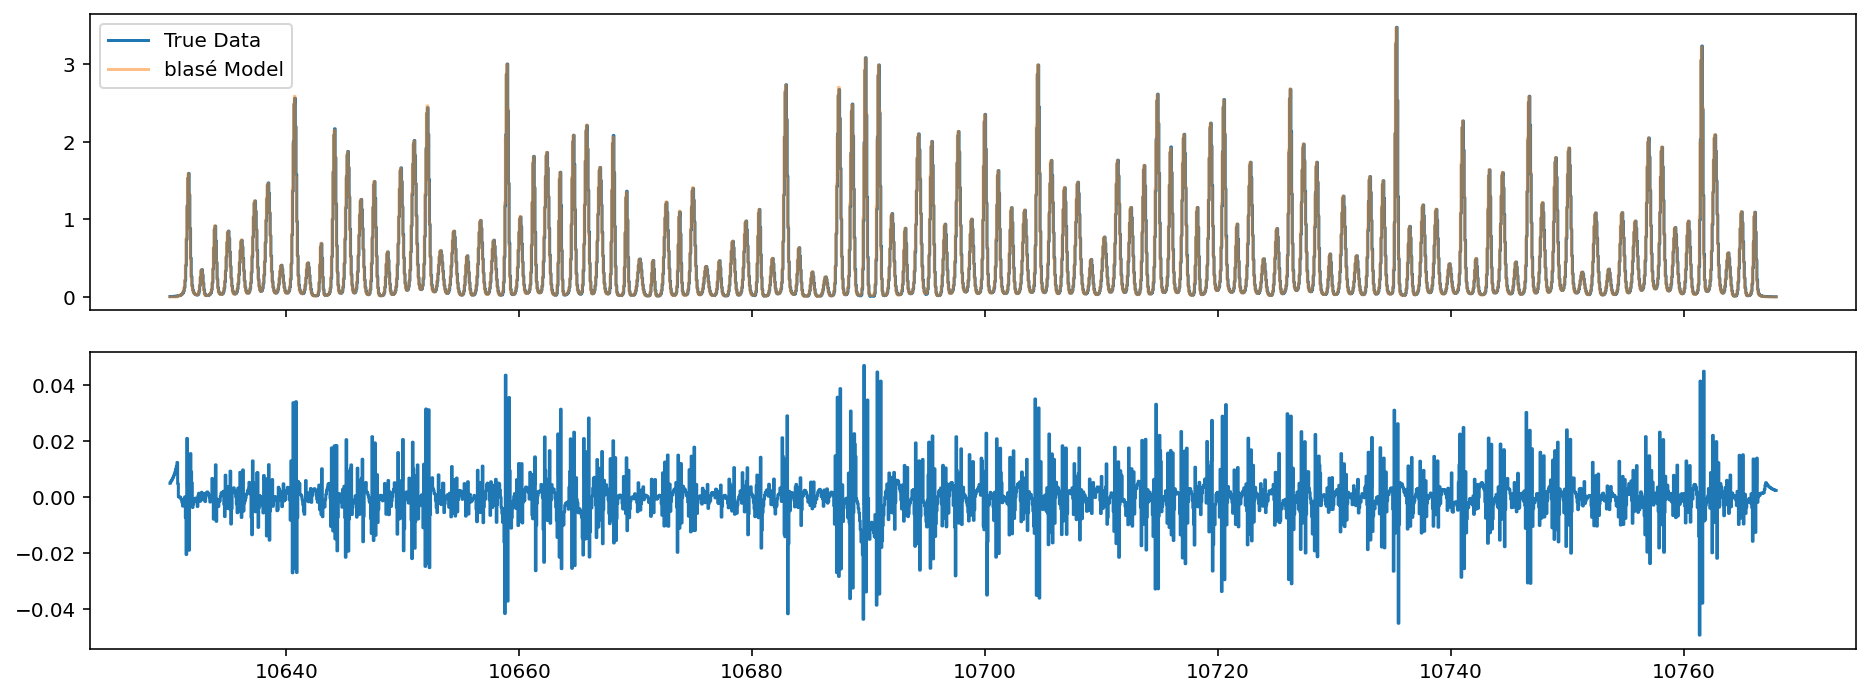

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(13, 5), sharex=True)
fig.tight_layout()
ax1.step(spectrum.wavelength, spectrum.flux, where='mid', label='True Data');
ax1.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(), label='blasé Model', alpha=0.5);
ax2.step(spectrum.wavelength,residual)
ax1.legend();

Hooray! We match the data pretty well!

In [43]:
np.std(residual)

<Quantity 0.00923193>

(10690.0, 10710.0)

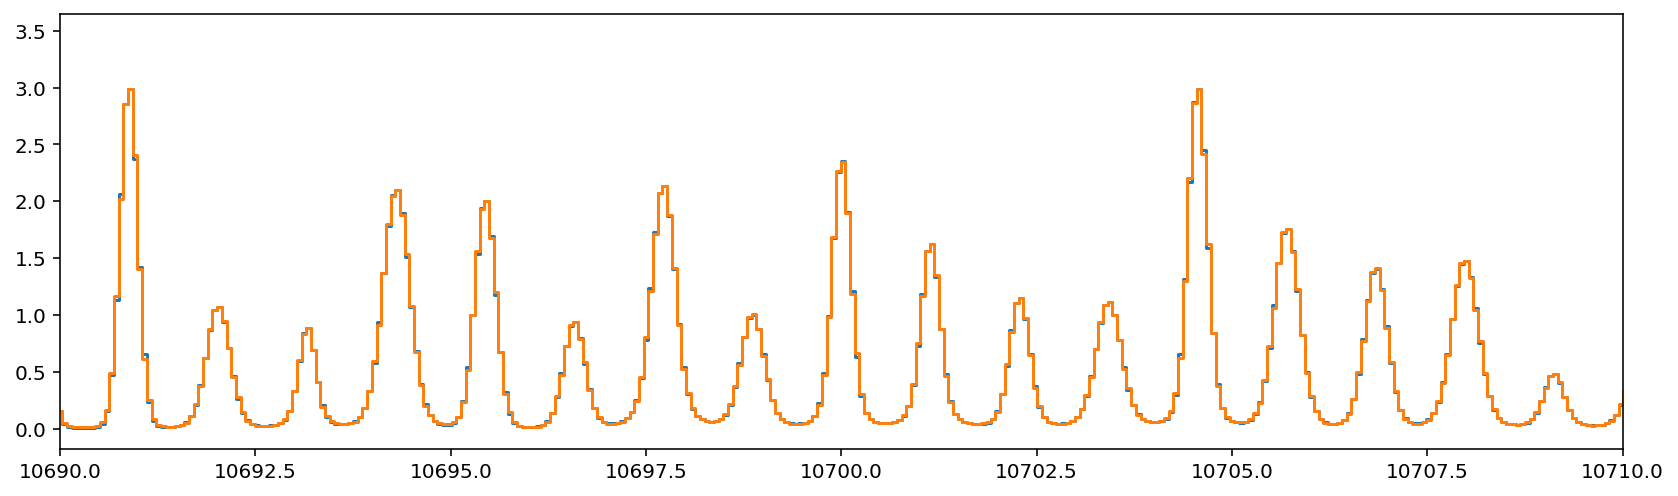

In [44]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.step(spectrum.wavelength, spectrum.flux, where='mid');
ax.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(), where='mid');
ax.set_xlim(10690, 10710)

Looks great, albeit not perfect-- we are resampling spectra, which should have an effect here...

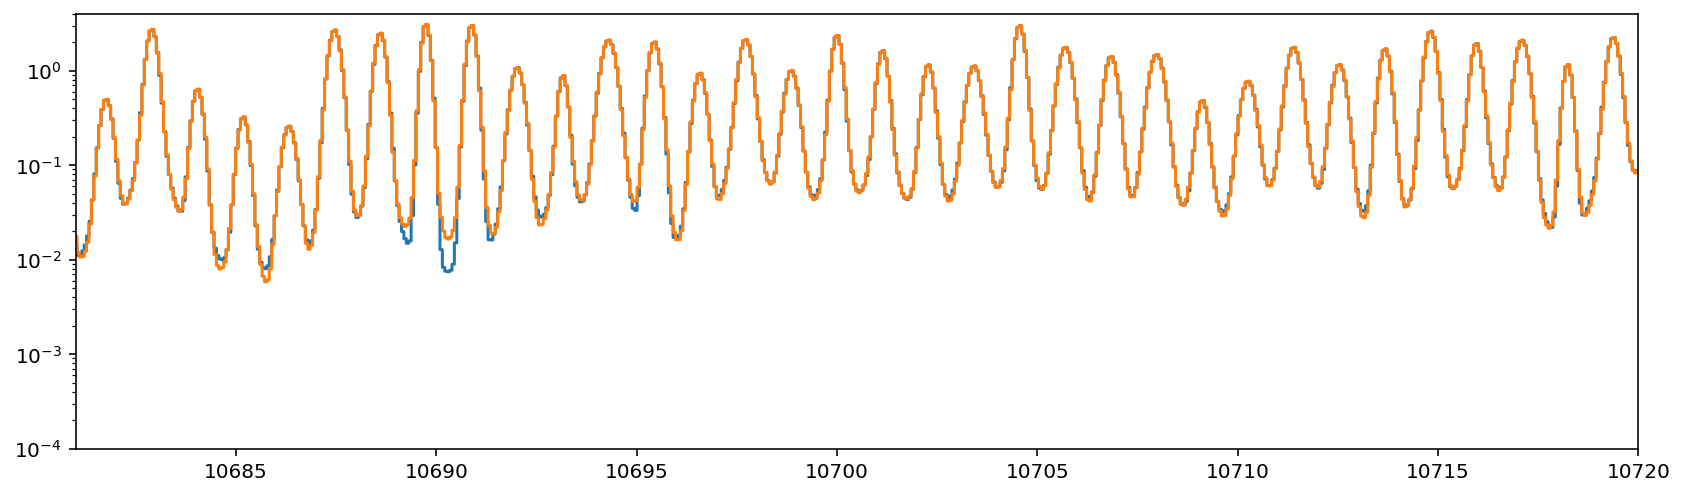

In [45]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.step(spectrum.wavelength, spectrum.flux, where='mid');
ax.step(spectrum.wavelength, detector_flux.detach().cpu().numpy(), where='mid');
ax.set_xlim(10681, 10720)
ax.set_ylim(1e-4, 4)
plt.yscale('log')

A ha! Our Voigt profile drops off too quickly--- we need heavier tails!  Something is wrong in our prescription...

### Inspect the individual stellar and telluric components

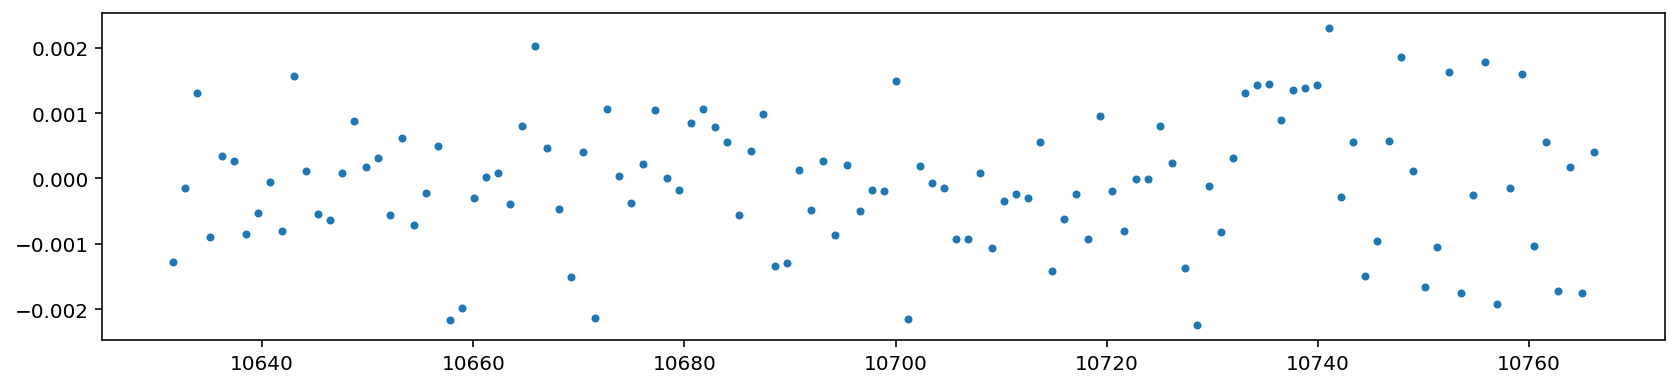

In [46]:
fig, ax = plt.subplots(figsize=(14,3))
plt.plot(true_lam_centers, emission_model.lam_centers.detach()-true_lam_centers, '.')

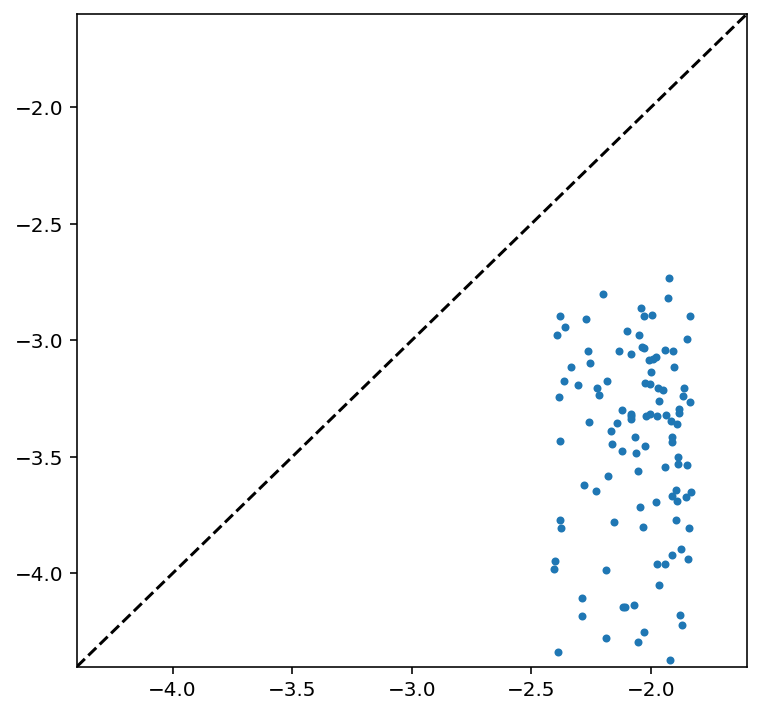

In [47]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(np.log(true_sigmas), emission_model.sigma_widths.detach(), '.')
ax.set_xlim(-4.4, -1.6)
ax.set_ylim(-4.4, -1.6)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='k')

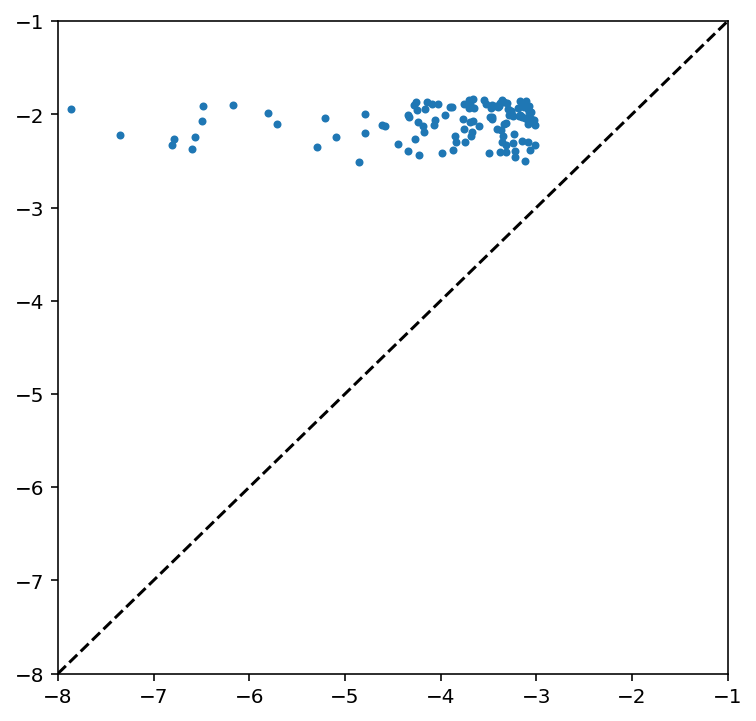

In [48]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(np.log(true_gammas), emission_model.gamma_widths.detach(), '.')
ax.set_xlim(-8, -1)
ax.set_ylim(-8, -1)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='k');

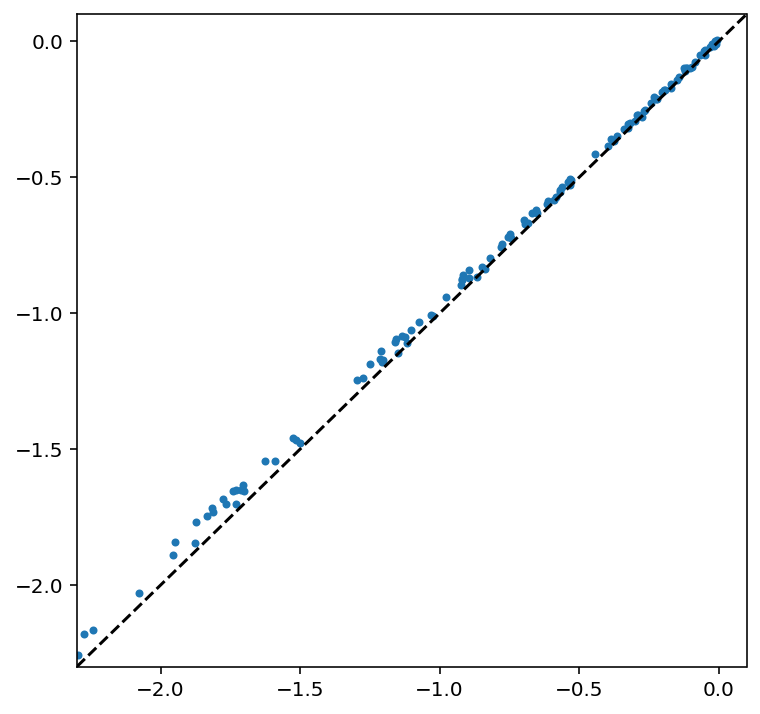

In [49]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(np.log(true_amplitudes), emission_model.amplitudes.detach(), '.')
ax.set_xlim(-2.3, 0.1)
ax.set_ylim(-2.3, 0.1)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', color='k');

In [50]:
retrieved_sigmas = torch.exp(emission_model.sigma_widths.detach()).numpy()
retrieved_gammas = torch.exp(emission_model.gamma_widths.detach()).numpy()
retrieved_amps = torch.exp(emission_model.amplitudes.detach()).numpy()

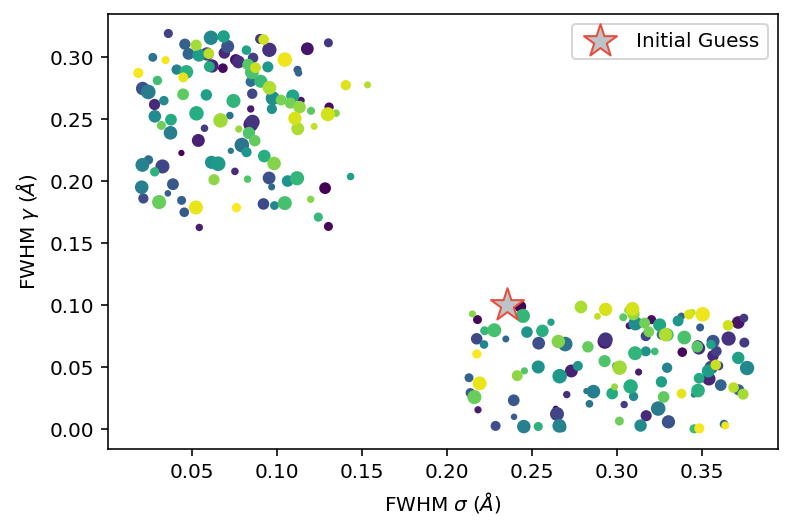

In [52]:
plt.scatter(2.355*true_sigmas, 2*true_gammas, s=true_amplitudes*40, c=true_lam_centers)

plt.scatter(2.355*retrieved_sigmas, 2*retrieved_gammas, s=retrieved_amps*40, c=true_lam_centers)

plt.xlabel('FWHM $\sigma \; (\AA)$')
plt.ylabel('FWHM $\gamma \; (\AA)$')
plt.scatter([2.355*guess_sigma], [2*guess_gamma], marker='*', s=300, color='#bdc3c7', ec='#e74c3c', label='Initial Guess')
plt.legend();

## Insights

Weird! We find an incompatible locus of posterior parameters--- why?

We have nearly-degenerate families of solutions: you can turn up $\sigma$ and down $\gamma$ (or vice versa) and get about the same answer.  We could/should have instead fit for FWHM and then a shape parameter $(\in 0-1)$.  With that parameterization we would get an exact FWHM constraint, but only a weak constraint on the shape parameter. We may want to do that moving forward!


Even still, it might seem odd that a noise-free spectrum doesn't converge to the exact input, after all there is zero noise added to the input.  Here are some reasons why we still don't get the "right answer":


- We chose Voigt wings that are weak and only manifest near zero flux, where other factors may dominate.  
- Pixel resampling could matter at this level
- The approximations in our implementaiton of the ExoJAX HJERT may be inexact
- The wingcut could matter
- A bug somewhere
- Initial guess matters